In [55]:
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import *
from qiskit.circuit import *
import math
from numpy.random import random
from scipy.optimize import minimize
import networkx as nx

In [56]:
# This notebook implements QAOA, following the example in the Qiskit textbook (https://qiskit.org/textbook/ch-applications/qaoa.html), to solve a max-cut problem on a random graph with n vertices.
# In our example n=12
n = 12

In [57]:
# We also set the backend, number of shots, and classical optimization algorithm
backend = Aer.get_backend('qasm_simulator')
nshots = 2048
opt = 'COBYLA'
# And finally we set the number of times we should alternatingly apply the problem circuit and the mixing circuit
p = 3

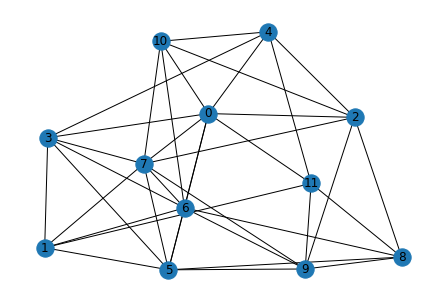

In [58]:
# First, we create the graph.
# The graph has n vertices, and for each pair of vertices, an edge is added with 50% probability.
G = nx.Graph()
G.add_nodes_from(range(0,n))
for i in range(0,n):
        for j in range(i+1,n):
            if random() < 0.5:
                G.add_edge(i,j)
# Draw our graph
nx.draw(G, with_labels=True)

We now creative the mixing circuit $e^{-i\beta X_0} e^{-i\beta X_1} \cdots e^{-i\beta X_{n-1}}$

In [59]:
beta = Parameter("beta")
qc_mix = QuantumCircuit(n)
for i in range(0,n):
    qc_mix.rx(2*beta,i)

We now create the problem circuit. 
For the max-cut problem, the unitary can be expressed as a product of terms $e^{-i\gamma Z_i \otimes Z_j}$ where $(i,j)$ is an edge of the graph. Each of these terms can be implemented in Qiskit by an rzz gate.

In [60]:
gamma = Parameter("gamma")
qc_p = QuantumCircuit(n)
for edge in list(G.edges()):
    qc_p.rzz(2*gamma,edge[0],edge[1])

In [61]:
# We build an initializing circuit to create a uniform superposition:
qc_init = QuantumCircuit(n)
for i in range(0,n):
    qc_init.h(i)
    
# We now create the full approximation circuit:
qc = qc_init.copy()
for j in range(0,p):
    qc.append(qc_p,range(0,n))
    qc.append(qc_mix,range(0,n))
qc.measure_all()
qc_transpiled = transpile(qc,backend=backend)


In [62]:
# We write a function which runs the quantum circuit the specified number of times (nshots defined above) and computes the (negative) expected number of edges cut by the returned partition
def expectation(params):
    # params should be a list of two parameters, beta and gamma
    b = params[0]
    g = params[1]
    # We assign the parameters in our transpiled approximation circuit:
    qc_to_run = qc_transpiled.assign_parameters({beta:b,gamma:g})
    results = backend.run(qc_to_run, shots=nshots).result().get_counts()
    #We now analyze each bitstring and keep a running total of the (negative) number of cuts we find
    sum_of_cuts = 0
    for bitstring, count in results.items():
        for i,j in G.edges():
            if bitstring[i] != bitstring[j]:
                sum_of_cuts -= count
    plot_histogram(results)
    # And we return the average number of cuts
    return sum_of_cuts/nshots
        
    

In [63]:
# We use this function to optimize beta and gamma using the chosen classical method 
beta_opt, gamma_opt = minimize(expectation, [1.0, 1.0], method=opt).x

In [64]:
# We now run our circuit with the optimized beta and gamma, and choose the highest-probability bitstring as our final answer
qc_to_run = qc_transpiled.assign_parameters({beta:beta_opt,gamma:gamma_opt})
results = backend.run(qc_to_run, shots=nshots).result().get_counts()
answer = max(results, key=results.get)
print(answer)
# The answer should be read left to right -- i.e., the first position refers to node 0, the second to node 1, etc.

110010100001


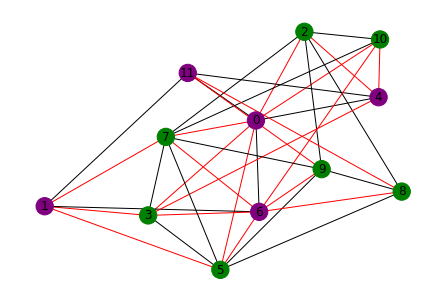

In [65]:
# We can color our graph to display this result: green and purple for the two different sections of the graph, and red for edges cut by this partition
node_color_list = ['green' if answer[node]=='0' else 'purple' for node in G.nodes()]
edge_color_list = ['black' if answer[int(edge[0])]==answer[int(edge[1])] else 'red' for edge in G.edges()]
nx.draw(G, with_labels=True, node_color=node_color_list, edge_color=edge_color_list)